In [ ]:
# SPDX-License-Identifier: MIT
# Copyright (c) 2018 University of Zurich

# Visualization - General structure
* *** Model *** : The model represents the data, and does nothing else. The model does NOT depend on the controller or the view.
    * EventsModel
    * StateVariablesModel
    * ...
    
* *** View *** : The view displays the model data, and sends user actions (e.g. button clicks) to the controller. The view can:
* be independent of both the model and the controller; or
* actually be the controller, and therefore depend on the model.
    * HistogramViewer
    * RasterplotViewer
    * LineplotViewer
    * ...
    
* *** Controller *** : The controller provides model data to the view, and interprets user actions such as button clicks. The controller depends on the view and the model. In some cases, the controller and the view are the same object.
    * HistogramController (called Histogram)
    * RasterplotController (called Rasterplot)
    * LineplotController (called Lineplot)
    * ...
    
* *** PlotSettings()***
    * font sizes
    * ...


# How to use it - in short
** 1) get data **

spikemonN1, spikemonN2, statemonN1, statemonN2 = run_your_own_brian_network()

** 2) define PLOTSETTING **

from teili.tools.visualizer.DataViewers import PlotSettings
MyPlotSettings = PlotSettings(fontsize_title=20, fontsize_legend=14, fontsize_axis_labels=14,
                               marker_size = 30,colors = ['r', 'b', 'g', 'c', 'k', 'm', 'y'])
                               
** 3) call CONTROLLER of desired type of plot, e.g. Histogram, Rasterplot, Lineplot, ... **

from teili.tools.visualizer.DataControllers import Histogram
DataModel_to_attr =  [(spikemonN1, 'i'), (spikemonN2, 'i')]
subgroup_labels    = ['N1',               'N2']
HC = Histogram(MyPlotSettings=MyPlotSettings,
                 DataModel_to_attr=DataModel_to_attr,
                 subgroup_labels=subgroup_labels,
                 backend='matplotlib')

### If you want to change anything else on the main figure/window or one of the subplots ... 

... you can directly access the mainfigure (matplotlib: figure, pyqtgraph: qt-window) as
* **my_controller.mainfig**
* or the corresponding subplot under **my_controller.subfig**

# How to use it - the slightly longer version

In [1]:
%pylab inline
import numpy as np
import os
import sys
sys.path.append(os.getenv("HOME")+'/Dropbox/src/teili/')

from brian2 import us, ms, second, prefs, defaultclock, start_scope, SpikeGeneratorGroup, SpikeMonitor, StateMonitor
import matplotlib.pylab as plt
import pyqtgraph as pg
from PyQt5 import QtGui

from teili.core.groups import Neurons, Connections
from teili import TeiliNetwork
from teili.models.neuron_models import DPI
from teili.models.synapse_models import DPISyn
from teili.models.parameters.dpi_neuron_param import parameters as neuron_model_param
from teili.models.parameters.dpi_synapse_param import parameters as synapse_model_param

QtApp = QtGui.QApplication([])

Populating the interactive namespace from numpy and matplotlib


In [2]:
def run_brian_network():
    prefs.codegen.target = "numpy"
    defaultclock.dt = 10 * us
    
    start_scope()
    N_input, N_N1, N_N2 = 1, 5, 3
    duration_sim = 100
    Net = TeiliNetwork()
    # setup spike generator
    spikegen_spike_times = np.sort(np.random.choice(size=500, a=np.arange(float(defaultclock.dt), float(duration_sim*ms)*0.9,
                                                                          float(defaultclock.dt*5)), replace=False)) * second
    spikegen_neuron_ids  = np.zeros_like(spikegen_spike_times) / ms
    gInpGroup = SpikeGeneratorGroup(N_input, indices=spikegen_neuron_ids,
                                    times=spikegen_spike_times, name='gtestInp')
    # setup neurons
    testNeurons1 = Neurons(N_N1, equation_builder=DPI(num_inputs=2), name="testNeuron")
    testNeurons1.set_params(neuron_model_param)
    testNeurons2 = Neurons(N_N2, equation_builder=DPI(num_inputs=2), name="testNeuron2")
    testNeurons2.set_params(neuron_model_param)
    # setup connections
    InpSyn = Connections(gInpGroup, testNeurons1, equation_builder=DPISyn(), name="testSyn", verbose=False)
    InpSyn.connect(True)
    InpSyn.weight = '200 + rand() * 100'
    Syn = Connections(testNeurons1, testNeurons2, equation_builder=DPISyn(), name="testSyn2", verbose=False)
    Syn.connect(True)
    Syn.weight = '200 + rand() * 100'
    # spike monitors input and network
    spikemonInp = SpikeMonitor(gInpGroup, name='spikemonInp')
    spikemonN1 = SpikeMonitor(testNeurons1, name='spikemon')
    spikemonN2 = SpikeMonitor(testNeurons2, name='spikemonOut')
    # state monitor neurons
    # statemonN1 = StateMonitor(testNeurons1, variables=["Iin", "Imem"], record=[0, 3], name='statemonNeu')
    statemonN1 = StateMonitor(testNeurons1, variables=["Iin", "Iahp"], record=True, name='statemonNeu')
    # statemonN2 = StateMonitor(testNeurons2, variables=['Iahp'], record=0, name='statemonNeuOut')
    statemonN2 = StateMonitor(testNeurons2, variables=['Imem'], record=True, name='statemonNeuOut')    
    
    Net.add(gInpGroup, testNeurons1, testNeurons2, InpSyn, Syn, spikemonN1, spikemonN2, statemonN1, statemonN2)
    # run simulation
    Net.run(duration_sim * ms)
    print ('Simulation run for {} ms'.format(duration_sim))
    return spikemonN1, spikemonN2, statemonN1, statemonN2

# 1. Get the data to plot

## Option A: run brian network to get SpikeMonitors and StateMonitors

In [3]:
''' Run brian network and return SpikeMonitors and StateMonitors of different variables and neurongroups '''
spikemonN1, spikemonN2, statemonN1, statemonN2 = run_brian_network()

Simulation run for 100 ms


## Option B: create DataModel instance from arrays, lists or brian-SpikeMonitors/StateMonitors

### Available DataModels:
* EventsModels --> stores neuron_ids and spike_times
* StateVariablesModel --> stores any number of variables with their name and the list of timepoints when the variable was sampled

### EventsModel

In [4]:
# create from array/list
from teili.tools.visualizer.DataModels import EventsModel
neuron_ids  = [1, 1, 1, 2, 3, 1, 4, 5]
spike_times = [11, 14, 14, 16, 17, 25, 36, 40]
EM = EventsModel(neuron_ids=neuron_ids, spike_times=spike_times)

# create from brian spike monitor
EM = EventsModel.from_brian_spike_monitor(spikemonN1)

print('Then the created EventsModel EM has the following attributes:')
for var in vars(EM):
    print(var,': \n', getattr(EM, var))

Then the created EventsModel EM has the following attributes:
neuron_ids : 
 [3 4 1 0 2 3 4 1 0 2 3 4 1 0 2 3 4 1 0 2 3 4 1 0 2 3 4 1 0 2 3 4 1 0 2 3 4
 1 0 2 3 4 1 0 2 3 4 1 0 2 3 4 1 0 2 3 4 1 0 2 3 4 1 0 3 2 4 1 3 0 2 4 1 3
 0 2 4 1 3 0 2 4 1 3 0 2 4 3 1 0 2 4 3 1 0 2 4 3 1 0 2 4 3 1 0 2 4 3 1 0 2
 4 3 1 0 2 4 3 1 0 2 4 3 1 0 2 3 4 1 0 2 3 4 1 0 3 2 4 1 0 3 4 2 1 3 0 4 2
 1 3 0 4 2 1 3 0 4 2 1 3 0 4 2 1 3 4 0 2 1 3 4 0 2 1 3 4 0 2 1 3 4 0 2 3 1
 4 0 2 3 1 4 0 2 3 1 4 0 3 2 1 4 0 3 2 1]
spike_times : 
 [0.00387 0.004   0.00405 0.00411 0.00413 0.00628 0.00651 0.00659 0.00669
 0.00673 0.0085  0.0088  0.00891 0.00903 0.00908 0.0107  0.0111  0.01124
 0.01139 0.01145 0.01278 0.01326 0.01344 0.01363 0.0137  0.01491 0.01552
 0.01574 0.01595 0.01603 0.01699 0.01764 0.01788 0.01812 0.01821 0.01907
 0.01984 0.02012 0.02039 0.02049 0.02108 0.02183 0.02216 0.02247 0.02259
 0.02304 0.02391 0.02426 0.0246  0.02473 0.02506 0.02604 0.02644 0.02684
 0.027   0.02719 0.02822 0.02867 0.02914 0.02932 0.0

### StateVariablesModel

In [5]:
from teili.tools.visualizer.DataModels import StateVariablesModel

# create from array/list
state_variable_names = ['var_name']
num_neurons, num_timesteps = 6, 50
state_variables       = [np.random.random((num_neurons, num_timesteps))]
state_variables_times = [np.linspace(0, 100, num_timesteps)]
SVM = StateVariablesModel(state_variable_names, state_variables, state_variables_times)

# from brian state monitorS
skip_not_rec_neuron_ids=False
SVM = StateVariablesModel.from_brian_state_monitors([statemonN1, statemonN2], skip_not_rec_neuron_ids)

skip_not_rec_neuron_ids=True
SVM = StateVariablesModel.from_brian_state_monitors([statemonN1, statemonN2], skip_not_rec_neuron_ids)

print('Then the created StateVariablesModel SVM has the following attributes:')
for var in vars(SVM):
    print(var,': \n', getattr(SVM, var))

Then the created StateVariablesModel SVM has the following attributes:
Iin : 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 ...
 [6.82521123e-09 7.02939025e-09 6.74769896e-09 7.76629202e-09
  7.21872104e-09]
 [6.81237889e-09 7.01617406e-09 6.73501234e-09 7.75169045e-09
  7.20514890e-09]
 [6.79957068e-09 7.00298271e-09 6.72234958e-09 7.73711634e-09
  7.19160228e-09]]
t_Iin : 
 [0.000e+00 1.000e-05 2.000e-05 ... 9.997e-02 9.998e-02 9.999e-02]
Iahp : 
 [[5.00000000e-13 5.00000000e-13 5.00000000e-13 5.00000000e-13
  5.00000000e-13]
 [5.00000000e-13 5.00000000e-13 5.00000000e-13 5.00000000e-13
  5.00000000e-13]
 [5.00000000e-13 5.00000000e-13 5.00000000e-13 5.00000000e-13
  5.00000000e-13]
 ...
 [2.35349697e-11 2.45322975e-11 2.37997191e-11 2.54116963e-11
  2.38412778e-11]
 [2.35283328e-11 2.452537

# 2. Plot the collected data
## 2.1 Define PlotSettings
* The PlotSettings are defined only once for all the plots that will be created. This should make it easier to get consistent color-codings, fontsizes and markersize across different plots.
* The colors can be defined as RGBA to additionally define the transparency

In [6]:
from teili.tools.visualizer.DataViewers import PlotSettings
MyPlotSettings = PlotSettings(fontsize_title=20, fontsize_legend=14, fontsize_axis_labels=14,
                               marker_size = 30,             # default 5
                               colors = ['r', 'b'],          # default ['r', 'b', 'g', 'c', 'k', 'm', 'y']
)

## 2.2 Call the DataController of the desired type of plot
So far in teili:
* Histogram
* Rasterplot
* Lineplot

## 2.2a)  Histogram

### Histogram - Inputs
    * DataModel_to_attr             --> e.g. [(spikemonN1, 'i'), (spikemonN2, 'i')] OR
                                                [(EventsModel, 'i'), (EventsModel, 'i')]
    * MyPlotSettings=PlotSettings()
    * subgroup_labels=None          --> e.g. ['Neurongroup N1', 'Neurongroup N2']
    * bins=None                     --> e.g. range(0,9)
    * orientation='vertical'        --> 'horizontal' OR 'vertical'
    * title='histogram
    * xlabel='bins'
    * ylabel='count',
    * backend='matplotlib'
    * show_immediately=False

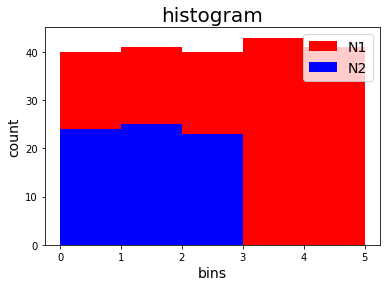

In [7]:
''' Simple example to plot a histogram of two NeuronGroups '''
from teili.tools.visualizer.DataControllers import Histogram

# plot data from BrianSpikeMontiors/StateMonitors
DataModel_to_attr =  [(spikemonN1, 'i'), (spikemonN2, 'i')]

# or plot data from DataModels
# EM1 = EventsModel.from_brian_spike_monitor(spikemonN1)
# EM2 = EventsModel.from_brian_spike_monitor(spikemonN2)
# DataModel_to_attr = {EM1: 'neuron_ids', EM2:'neuron_ids'}
subgroup_labels = ['N1', 'N2']

# MATPLOTLIB backend
HC = Histogram(DataModel_to_attr=DataModel_to_attr,
                MyPlotSettings=MyPlotSettings,
                subgroup_labels=subgroup_labels,
                backend='matplotlib')

In [ ]:
# PYQTGRAPH backend
HC = Histogram(DataModel_to_attr=DataModel_to_attr, 
                MyPlotSettings=MyPlotSettings,           
                subgroup_labels=subgroup_labels,
                backend='pyqtgraph',
                QtApp=QtApp, show_immediately=True)

## 2.2b) Rasterplot

### Rasterplot - Inputs

    * MyEventsModels                --> list of EventsModel or BrianSpikeMonitors
    * MyPlotSettings=PlotSettings()
    * subgroup_labels=None          --> ['N1', 'N2']
    * time_range=None               --> (0, 0.9)
    * neuron_id_range=None,         --> (0, 4)
    * title='raster plot'
    * xlabel='time
    * ylabel='count',
    * backend='matplotlib'
    * add_histogram=False           --> show histogram of spikes per neuron id next to rasterplot
    * show_immediately=False

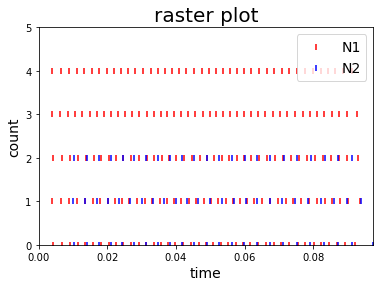

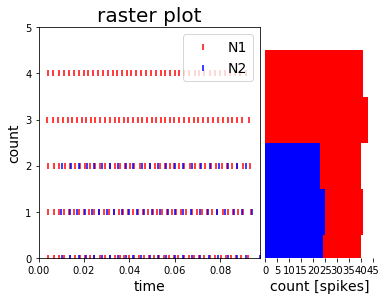

In [8]:
from teili.tools.visualizer.DataControllers import Rasterplot
''' Simple example to plot a rasterplot of two NeuronGroups '''

# plot data from BrianSpikeMontiors
MyEventsModels = [spikemonN1, spikemonN2]

# or plot data from EventsModel
# EM1 = EventsModel.from_brian_spike_monitor(spikemonN1)
# EM2 = EventsModel.from_brian_spike_monitor(spikemonN2)
# MyEventsModels = [EM1, EM2]

subgroup_labels = ['N1', 'N2']

# MATPLOTLIB backend - WITHOUT HISTOGRAM
RC = Rasterplot(MyEventsModels=MyEventsModels, MyPlotSettings=MyPlotSettings, subgroup_labels=subgroup_labels, backend='matplotlib')
# MATPLOTLIB backend - WITH HISTOGRAM
RC = Rasterplot(MyEventsModels=MyEventsModels, MyPlotSettings=MyPlotSettings, subgroup_labels=subgroup_labels, add_histogram=True)

In [ ]:
# PYQTGRAPH backend - WITHOUT HISTOGRAM
RC = Rasterplot(MyEventsModels=MyEventsModels, MyPlotSettings=MyPlotSettings, subgroup_labels=subgroup_labels, backend='pyqtgraph', QtApp=QtApp)
# PYQTGRAPH backend - WITH HISTOGRAM
RC = Rasterplot(MyEventsModels=MyEventsModels, MyPlotSettings=MyPlotSettings, subgroup_labels=subgroup_labels,
                    add_histogram=True, backend='pyqtgraph', QtApp=QtApp, show_immediately=True)

## 2.2c) LinePlot

### Lineplot - Inputs

    * DataModel_to_x_and_y_attr --> e.g. [(statemonN1, ('Imem', 't_Imem')),
                                                   (statemonN2, ('Iahp', 't_Iahp'))]
                                            OR
                                         [(StateVariablesModel_N1, ('Imem', 't_Imem')),
                                                  (StateVariablesModel_N2, ('Iahp', 't_Iahp'))]
    * MyPlotSettings=PlotSettings()
    * subgroup_labels=None      --> ['N1', 'N2']
    * x_range=None,             --> (0, 0.9)
    * y_range=None,             --> (0, 4)
    * title='Lineplot'
    * xlabel=None
    * ylabel=None
    * backend='matplotlib'
    * show_immediately=False

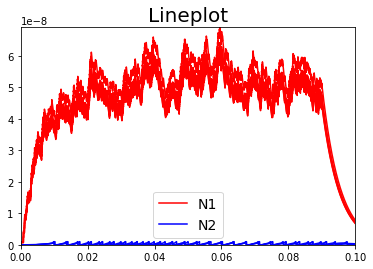

In [9]:
from teili.tools.visualizer.DataControllers import Lineplot
''' Simple example to plot a lineplot of two NeuronGroups '''

# plot data from BrianSpikeMontiors
DataModel_to_x_and_y_attr = [(statemonN1, ('t', 'Iin')), (statemonN2, ('t', 'Imem'))]
# or plot data from StateVariablesModel
SVM_N1 = StateVariablesModel.from_brian_state_monitors([statemonN1])
SVM_N2 = StateVariablesModel.from_brian_state_monitors([statemonN2])
DataModel_to_x_and_y_attr = [(SVM_N1, ('t_Iin', 'Iin')), (SVM_N2, ('t_Imem', 'Imem'))]

subgroup_labels = ['N1', 'N2']

# MATPLOTLIB backend
LC = Lineplot(DataModel_to_x_and_y_attr=DataModel_to_x_and_y_attr,
                  MyPlotSettings=MyPlotSettings,
                  subgroup_labels=subgroup_labels, 
                  backend='matplotlib')

In [ ]:
# PYQTGRAPH backend
LC = Lineplot(DataModel_to_x_and_y_attr=DataModel_to_x_and_y_attr,
                  MyPlotSettings=MyPlotSettings,
                  subgroup_labels=subgroup_labels, 
                  backend='pyqtgraph', QtApp=QtApp, show_immediately=True)

# Additional functionalities

# A1) Combine different plots
## ... with matplotlib

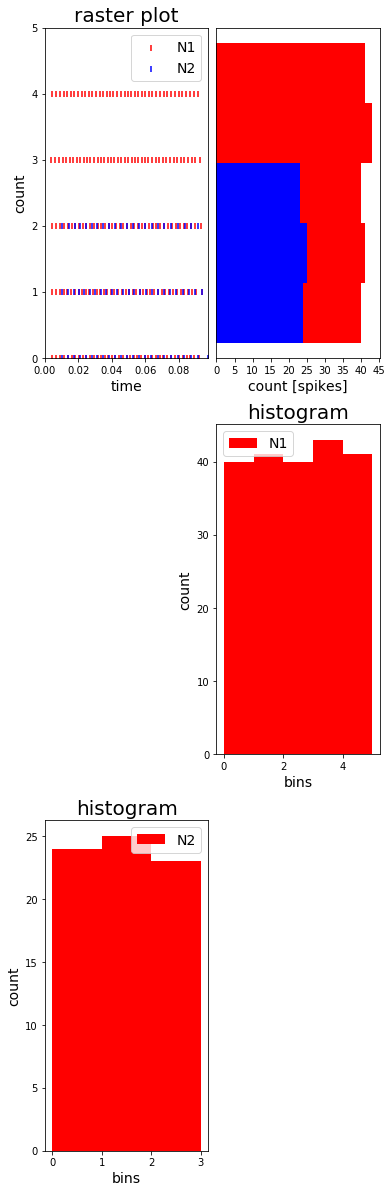

In [10]:
# define plot structure BEFOREHAND
mainfig = plt.figure()
subfig1 = mainfig.add_subplot(321)
subfig2 = mainfig.add_subplot(322)
subfig3 = mainfig.add_subplot(324)
subfig4 = mainfig.add_subplot(325)

plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=4., wspace=0.05, hspace=0.2)

MyEventsModels = [spikemonN1, spikemonN2]
subgroup_labels = ['N1', 'N2']
RC = Rasterplot(MyEventsModels=MyEventsModels, MyPlotSettings=MyPlotSettings, subgroup_labels=subgroup_labels,
                 mainfig=mainfig, subfig_rasterplot=subfig1, subfig_histogram = subfig2,
                 add_histogram=True, show_immediately=False)

DataModel_to_attr = [(spikemonN1, 'i')]
subgroup_labels = ['N1']
HC = Histogram(DataModel_to_attr=DataModel_to_attr, MyPlotSettings=MyPlotSettings, 
                 subgroup_labels=subgroup_labels, mainfig=mainfig, subfig=subfig3, show_immediately=False)

DataModel_to_attr = [(spikemonN2, 'i')]
subgroup_labels = ['N2']
HC = Histogram(DataModel_to_attr=DataModel_to_attr, MyPlotSettings=MyPlotSettings, 
             subgroup_labels=subgroup_labels, mainfig=mainfig, subfig=subfig4, show_immediately=True)

## ... with pyqtgraph

In [ ]:
# define plot structure BEFOREHAND
mainfig = pg.GraphicsWindow()
subfig1 = mainfig.addPlot(row=0, col=0)
subfig2 = mainfig.addPlot(row=0, col=1)
subfig2.setYLink(subfig1)
subfig3 = mainfig.addPlot(row=1, col=1)
subfig4 = mainfig.addPlot(row=2, col=0)

plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=4., wspace=0.05, hspace=0.2)

MyEventsModels = [spikemonN1, spikemonN2]
subgroup_labels = ['N1', 'N2']
RC = Rasterplot(MyEventsModels=MyEventsModels, MyPlotSettings=MyPlotSettings, subgroup_labels=subgroup_labels,
                         mainfig=mainfig, subfig_rasterplot=subfig1, subfig_histogram = subfig2, QtApp=QtApp,
                         backend='pyqtgraph', add_histogram=True, show_immediately=False)

DataModel_to_attr = [(spikemonN1, 'i')]
subgroup_labels = ['N1']
HC = Histogram(DataModel_to_attr=DataModel_to_attr, MyPlotSettings=MyPlotSettings, 
                         subgroup_labels=subgroup_labels,
                         backend='pyqtgraph', mainfig=mainfig, subfig=subfig3,  QtApp=QtApp,
                         show_immediately=False)

DataModel_to_attr = [(spikemonN1, 'i')]
subgroup_labels = ['N2']
HC = Histogram(DataModel_to_attr=DataModel_to_attr, MyPlotSettings=MyPlotSettings,
                         subgroup_labels=subgroup_labels,
                         backend='pyqtgraph', mainfig=mainfig, subfig=subfig4, QtApp=QtApp,
                         show_immediately=True)

# A2) Add second plot with a detailed view of a given plot

In [ ]:
''' Create original plot of which you would like to have a detailed version as well TWICE (sorry, about that...)'''
MyEventsModels = [spikemonN1, spikemonN2]
subgroup_labels = ['N1', 'N2']

mainfig = pg.GraphicsWindow()
subfig1 = mainfig.addPlot(row=0, col=0)
mainfig.nextRow()
subfig2 = mainfig.addPlot(row=1, col=0)


RC_org = Rasterplot(MyEventsModels=MyEventsModels, MyPlotSettings=MyPlotSettings, subgroup_labels=subgroup_labels,
                              mainfig=mainfig, subfig_rasterplot=subfig1,
                         QtApp=QtApp, backend='pyqtgraph', show_immediately=False)
RC_detail = Rasterplot(MyEventsModels=MyEventsModels, MyPlotSettings=MyPlotSettings, subgroup_labels=subgroup_labels,
                                 mainfig=mainfig, subfig_rasterplot=subfig2,
                         QtApp=QtApp, backend='pyqtgraph', show_immediately=False)

RC_org.connect_detailed_subplot(filled_subplot_original_view=RC_org.viewer.subfig_rasterplot,
                                filled_subplot_detailed_view=RC_detail.viewer.subfig_rasterplot,
                                show_plot=True)